In [9]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import time
import datetime
%matplotlib inline
from pandas import DataFrame
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error , accuracy_score, recall_score, precision_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

In [3]:
# 前処理（trainデータ）
train = pd.read_csv("train.csv")
train["re_rate"] = train["host_response_rate"].str.split("%",expand = True)[0].astype(float)
today = datetime.datetime.today()
train["first_review"] = pd.to_datetime(train["first_review"])
train["host_since"] = pd.to_datetime(train["host_since"])
train["last_review"] = pd.to_datetime(train["last_review"])
train["first_counts"] = today - train["first_review"]
train["first_counts"] = train["first_counts"].dt.days
train["host_counts"] = today - train["host_since"]
train["host_counts"] = train["host_counts"].dt.days
train["last_counts"] = today - train["last_review"]
train["last_counts"] = train["last_counts"].dt.days
train.drop(["amenities"],axis = 1,inplace=True)
train.drop(["description","first_review","host_response_rate","host_since","last_review","name","neighbourhood"],axis = 1,inplace=True)
train.drop(["thumbnail_url"],axis = 1,inplace=True)
train.drop(["zipcode"],axis = 1,inplace=True)
train["y"] = train["y"].astype("int")
train = train.interpolate()
train_d = pd.get_dummies(train)
train_d.drop(['property_type_Casa particular', 'property_type_Earth House', 'property_type_Island', 'property_type_Parking Space', 'property_type_Tipi', 'property_type_Train', 'property_type_Treehouse', 'property_type_Vacation home'],axis=1,inplace=True)
train_d = train_d.dropna()
train_d.drop(["id"],axis = 1,inplace=True)
from sklearn.model_selection import train_test_split
X = train_d.drop(["y"],axis = 1)
y = train_d["y"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=10)

In [11]:
# 前処理（testデータ）
test = pd.read_csv("test.csv")
test["re_rate"] = test["host_response_rate"].str.split("%",expand = True)[0].astype(float)
test["first_review"] = pd.to_datetime(test["first_review"])
test["host_since"] = pd.to_datetime(test["host_since"])
test["last_review"] = pd.to_datetime(test["last_review"])
test["first_counts"] = today - test["first_review"]
test["first_counts"] = test["first_counts"].dt.days
test["host_counts"] = today - test["host_since"]
test["host_counts"] = test["host_counts"].dt.days
test["last_counts"] = today - test["last_review"]
test["last_counts"] = test["last_counts"].dt.days
test.drop(["amenities"],axis = 1,inplace=True)
test.drop(["description","first_review","host_response_rate","host_since","last_review","name","neighbourhood"],axis = 1,inplace=True)
test.drop(["thumbnail_url"],axis = 1,inplace=True)
test.drop(["zipcode"],axis = 1,inplace=True)
test_d = pd.get_dummies(test)
test_d = test_d.interpolate()
test_d.drop(['property_type_Lighthouse'],axis = 1,inplace=True)
test_d.drop(["id"],axis= 1,inplace=True)

In [4]:
# 評価指標は二乗平均平方根誤差（RMSE）
params = {'metric' : 'rmse'}
lgb_train = lgb.Dataset(X_train,y_train)
lgb_test = lgb.Dataset(X_test,y_test)

In [5]:
# パラーメータを設定
params = {'objective': 'regression',
 'metric': 'rmse',
 'feature_pre_filter': False,
 'lambda_l1': 1.9,
 'lambda_l2': 0.9,
 'num_leaves': 19,
 'feature_fraction': 0.7,
 'feature_fraction': 0.73,
 'bagging_fraction': 0.999,
 'min_child_samples': 25,
 'num_iterations': 410,
 'early_stopping_round': None,
}

C:\Users\81902\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\81902\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1969
[LightGBM] [Info] Number of data points in the train set: 38907, number of used features: 65
[LightGBM] [Info] Start training from score 159.871848


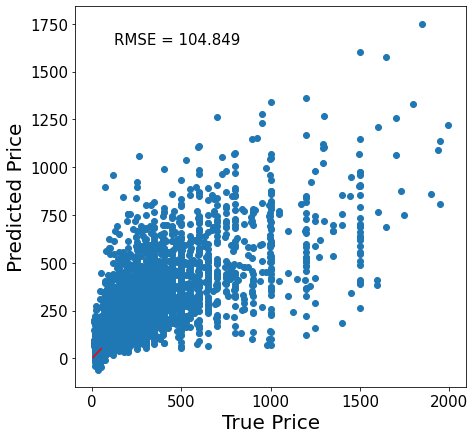

In [6]:
# 訓練データから回帰モデルを作る
gbm = lgb.train(params, lgb_train)
# テストデータを用いて予測精度を確認する
test_predicted = gbm.predict(X_test)
predicted_df = pd.concat([y_test.reset_index(drop=True), pd.Series(test_predicted)], axis = 1)
predicted_df.columns = ['true', 'predicted']
# 予測値を図で確認する関数の定義
def Prediction_accuracy(predicted_df):
    RMSE = np.sqrt(mean_squared_error(predicted_df['true'], predicted_df['predicted']))
    plt.figure(figsize = (7,7))
    ax = plt.subplot(111)
    ax.scatter('true', 'predicted', data = predicted_df)
    ax.set_xlabel('True Price', fontsize = 20)
    ax.set_ylabel('Predicted Price', fontsize = 20)
    plt.tick_params(labelsize = 15)
    x = np.linspace(5, 50)
    y = x
    ax.plot(x, y, 'r-')
    plt.text(0.1, 0.9, 'RMSE = {}'.format(str(round(RMSE,3))),transform = ax.transAxes, fontsize = 15)
# 予測値を図で確認する
Prediction_accuracy(predicted_df)

In [13]:
# 予想値の取得
predictions = gbm.predict(test_d)
ids = test.loc[:,["id"]]
predictions_pd = pd.DataFrame(predictions)
result_last = pd.concat([ids,predictions_pd], axis=1)
result_last.to_csv("result.csv",index = False)